In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Leopard seal vocalizations
Source:
- https://www.mobysound.org/
- http://localhost:8186/tree/Datasets/mobysound/leopard_seal


**Note**: This dataset is very noisy

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [305]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter

### data locations

In [4]:
DSLOC = Path('/mnt/cube/Datasets/mobysound/leopard_seal/')
readme = DSLOC/'readme_1st.txt'
readme = [line for line in open(readme, 'r')]  

### Load labels

In [6]:
LABEL_LOC = DSLOC / 'low_double_trill.xls'

In [ ]:
rate = 1000

In [62]:
def get_sec(time_str):
    if '.' in time_str:
        time_str, ms = time_str.split('.')
    else:
        ms = '0'
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s) + float('.'+ms)

In [63]:
label_df = pd.read_excel(LABEL_LOC)
label_df['start_time_s'] = [get_sec(time_str) for time_str in label_df['Start time [hh:mm:ss.ss]'].values]
label_df['end_time_s'] = [get_sec(time_str) for time_str in label_df['End time [hh:mm:ss.ss]'].values]
len(label_df)

7249

In [65]:
label_df[:3]

,Start time [hh:mm:ss.ss],End time [hh:mm:ss.ss],Start time [s],End time [s],Duration [s],Low frequency [Hz],High frequency [Hz],Bandwidth [Hz],start_time_s,end_time_s
0,0:02:19.09,0:02:27.98,139.0927,147.9815,8.8889,247.8689,323.6066,75.7377,139.09,147.98
1,0:03:48.68,0:03:56.33,228.6791,236.3334,7.6543,319.6721,369.8361,50.1639,228.68,236.33
2,0:04:51.27,0:04:59.09,291.2697,299.0887,7.8189,259.6721,320.6557,60.9836,291.27,299.09


### Make wav dataset

In [130]:
wavs = list((DSLOC / 'data').glob('2*.wav'))
wavs.sort()
len(wavs)
wavs[:3]

[PosixPath('/mnt/cube/Datasets/mobysound/leopard_seal/data/20071216-0000.wav'),
 PosixPath('/mnt/cube/Datasets/mobysound/leopard_seal/data/20071216-0001.wav'),
 PosixPath('/mnt/cube/Datasets/mobysound/leopard_seal/data/20071216-0002.wav')]

In [246]:
long_wav = np.concatenate([load_wav(wav_loc)[1] for wav_loc in tqdm(wavs)])

In [247]:
len(long_wav)

230044268

In [131]:
wav_ds = pd.DataFrame(columns = ['rate', 'data', 'file', 'wloc', 'wav_st', 'wav_et', 'ds_len'])
st = 0
for wav_loc in tqdm(wavs):
    rate, data = load_wav(wav_loc)
    ds_len = len(data)/rate
    wav_ds.loc[len(wav_ds)] = [rate, data, wav_loc.stem, wav_loc, st, st+ds_len, ds_len]
    st+=ds_len

In [133]:
np.unique(wav_ds.rate.values)

array([1000], dtype=object)

In [134]:
wav_ds[:5]

,rate,data,file,wloc,wav_st,wav_et,ds_len
0,1000,"[-122, -787, -415, -390, 201, 232, 61, 281, 25...",20071216-0000,/mnt/cube/Datasets/mobysound/leopard_seal/data...,0,38.288,38.288
1,1000,"[38, -199, -19, -14, 141, 433, 125, 185, 532, ...",20071216-0001,/mnt/cube/Datasets/mobysound/leopard_seal/data...,38.288,100.280,61.992
2,1000,"[-192, -832, -217, 591, 379, 615, 610, 137, 17...",20071216-0002,/mnt/cube/Datasets/mobysound/leopard_seal/data...,100.28,160.292,60.012
3,1000,"[107, 110, -135, -70, 160, -185, -189, -14, 38...",20071216-0003,/mnt/cube/Datasets/mobysound/leopard_seal/data...,160.292,196.448,36.156
4,1000,"[-110, -266, -361, -76, -89, 55, 169, 483, -15...",20071216-0004,/mnt/cube/Datasets/mobysound/leopard_seal/data...,196.448,256.460,60.012


### grab a single test syllable

In [333]:
win_length_ms = 100
hop_length_ms = 10
print(win_length_ms/1000*rate)
hparams = HParams(  
    # spectrogramming
    win_length = int(rate/1000 * win_length_ms),
    n_fft = 2048,
    hop_length= int(rate/1000 * hop_length_ms),
    ref_level_db = 20,
    min_level_db = -70,
    # mel scaling
    num_mel_bins = 64,
    mel_lower_edge_hertz = 0,
    mel_upper_edge_hertz = 2000,
    # inversion
    power = 1.5, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
    #
)

100.0


In [334]:
syll_row

Start time [hh:mm:ss.ss]     41:26:36.78
End time [hh:mm:ss.ss]       41:26:40.41
Start time [s]                    149197
End time [s]                      149200
Duration [s]                      3.6349
Low frequency [Hz]               297.315
High frequency [Hz]              343.624
Bandwidth [Hz]                   46.3087
start_time_s                      149197
end_time_s                        149200
Name: 1000, dtype: object

In [335]:
syll_row = label_df.iloc[1000]
syll_data = long_wav[int(syll_row.start_time_s*rate):int(syll_row.end_time_s*rate)]
#syll_data = butter_bandpass_filter(syll_data, lowcut = syll_row['Low frequency [Hz]'], highcut=syll_row['High frequency [Hz]'], fs=rate, order=2)
spectrogram = spectrogram_tensorflow(int16_to_float32(syll_data), hparams)

(-0.5, 362.5, -0.5, 1024.5)

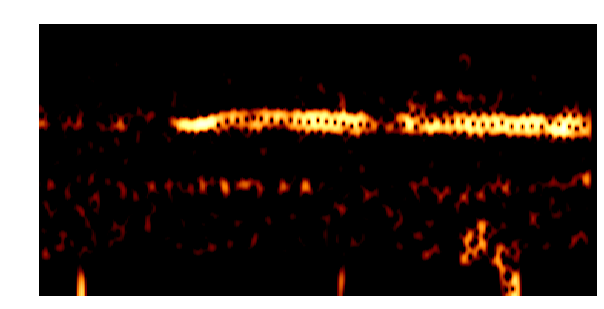

In [336]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(spectrogram.numpy().T, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
ax.axis('off')

### make syllable dataset

In [338]:
syllable_df = pd.DataFrame(columns=["data", "start_time_s", "end_time_s"])
for idx, syll_row in tqdm(label_df.iterrows(), total=len(label_df)):
    syll_data = long_wav[
        int(syll_row.start_time_s * rate) : int(syll_row.end_time_s * rate)
    ]
    #syll_data = butter_bandpass_filter(
    #    syll_data,
    #    lowcut=syll_row["Low frequency [Hz]"],
    #    highcut=syll_row["High frequency [Hz]"],
    #    fs=rate,
    #    order=2,
    #)
    #spectrogram = spectrogram_tensorflow(int16_to_float32(syll_data), hparams)
    syllable_df.loc[len(syllable_df)] = [
        syll_data,
        syll_row.start_time_s,
        syll_row.end_time_s,
    ]